In [1]:
# Import Libraries
import numpy as np
import torch
import torchvision.transforms as tvt
import torch.utils.data 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os
from pprint import pprint
from torchinfo import summary
import torchvision.datasets
import time
import datetime
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/home/dfarache/.conda/envs/cent7/2020.11-py38/eceDL2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Variables
train_dir = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/train"
eval_dir = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/eval"
path_to_model = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/model"
path_to_results = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/results"
batch_size = 16
image_size = 64 # 64x64 image size


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is on {device}")
device = torch.device(device)

Torch is on cuda


## Generate Dataloaders

In [3]:
def generate_dataloader(path, train="train", transform=None):
    dataset = torchvision.datasets.ImageFolder(path, transform=transform)
    print(f"Length of {train} dataset is {len(dataset)}")
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
    return dataloader

# Transformation to apply on the images
transform = tvt.Compose([tvt.Resize(image_size), 
                         tvt.CenterCrop(image_size), 
                         tvt.ToTensor(), 
                         tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get Trainloader
trainloader = generate_dataloader(path=train_dir, train="train", transform=transform)
testloader = generate_dataloader(path=eval_dir, train="eval", transform=transform)

Length of train dataset is 8213
Length of eval dataset is 1000


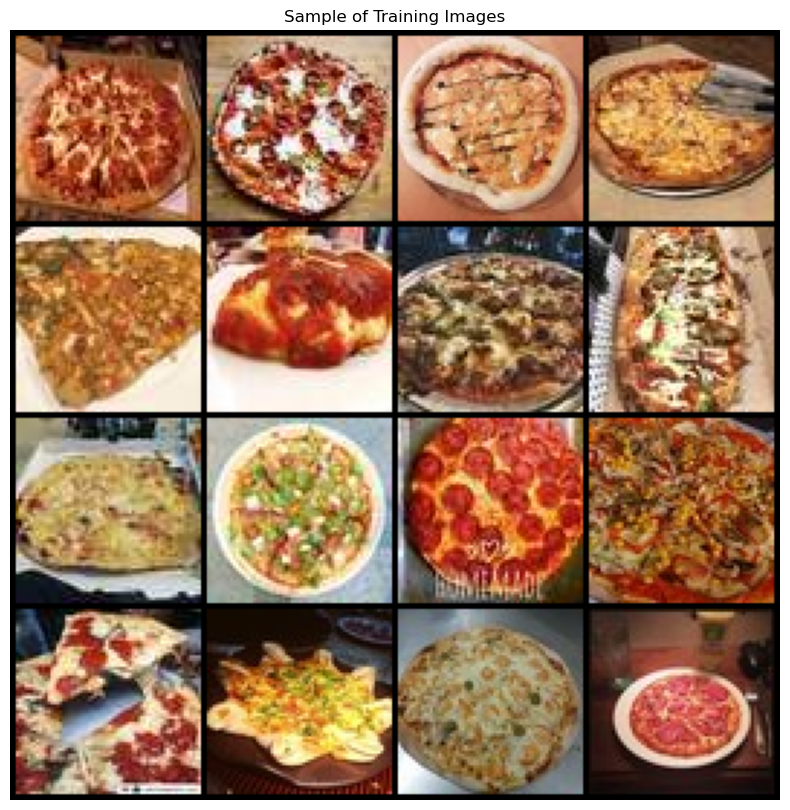

In [4]:
# Displaying a sample of the training images
images_in_batch, _ = next(iter(trainloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample of Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images_in_batch[:batch_size], padding=2, nrow=4, normalize=True),(1,2,0)))

# images,_ = next(iter(train_data_loader))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(torchvision.utils.make_grid(images[:32], padding=2, normalize=True),(1,2,0
# )));

## Creating the Networks

In [5]:
# Used by both DCGAN and Wasser GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Bias = False because we don't want to add a learnable parameter to the output
        self.latent_to_image = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)
        self.upsampler2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsampler3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsampler4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsampler5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=512)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        
        # Activation Function
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.latent_to_image(x)
        x = F.relu(self.bn1(x))

        x = self.upsampler2(x)
        x = F.relu(self.bn2(x))

        x = self.upsampler3(x)
        x = F.relu(self.bn3(x))

        x = self.upsampler4(x)
        x = F.relu(self.bn4(x))

        x = self.upsampler5(x)
        return self.tanh(x)

In [6]:
# Number of layers and learnable parameters in the Generator
netG = Generator()
num_layers = len(list(netG.parameters()))
num_learnable_parameters = sum(p.numel() for p in netG.parameters() if p.requires_grad)

print(f"Number of layers in the generator network: {num_layers}")
print(f"Number of learnable parameters in the generator network: {num_learnable_parameters}")
summary(netG, input_size=(batch_size, 100, image_size, image_size))

Number of layers in the generator network: 13
Number of learnable parameters in the generator network: 3576704


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [16, 3, 1072, 1072]       --
├─ConvTranspose2d: 1-1                   [16, 512, 67, 67]         819,200
├─BatchNorm2d: 1-2                       [16, 512, 67, 67]         1,024
├─ConvTranspose2d: 1-3                   [16, 256, 134, 134]       2,097,152
├─BatchNorm2d: 1-4                       [16, 256, 134, 134]       512
├─ConvTranspose2d: 1-5                   [16, 128, 268, 268]       524,288
├─BatchNorm2d: 1-6                       [16, 128, 268, 268]       256
├─ConvTranspose2d: 1-7                   [16, 64, 536, 536]        131,072
├─BatchNorm2d: 1-8                       [16, 64, 536, 536]        128
├─ConvTranspose2d: 1-9                   [16, 3, 1072, 1072]       3,072
├─Tanh: 1-10                             [16, 3, 1072, 1072]       --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0
Total mult-adds (T): 1.92
Input size (MB): 26.21

### DCGAN Networks

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_in1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv_in2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv_in3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv_in4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv_in5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
        self.conv_in6 = nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=2, padding=1)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024) 

        # Activation Function
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv_in1(x), negative_slope=0.2, inplace=True)
        x = self.bn1(self.conv_in2(x))
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.bn2(self.conv_in3(x))
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.bn3(self.conv_in4(x))
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.bn4(self.conv_in5(x))
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.sig(self.conv_in6(x))
        return x

In [8]:
# Number of layers and learnable parameters in the Discriminator
netD = Discriminator()
num_layers = len(list(netD.parameters()))
num_learnable_parameters = sum(p.numel() for p in netD.parameters() if p.requires_grad)

print(f"Number of layers in the discriminator network: {num_layers}")
print(f"Number of learnable parameters in the discriminator network: {num_learnable_parameters}")
summary(netD, input_size=(batch_size, 3, image_size, image_size))

Number of layers in the discriminator network: 20
Number of learnable parameters in the discriminator network: 11166401


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1, 1, 1]             --
├─Conv2d: 1-1                            [16, 64, 32, 32]          3,136
├─Conv2d: 1-2                            [16, 128, 16, 16]         131,200
├─BatchNorm2d: 1-3                       [16, 128, 16, 16]         256
├─Conv2d: 1-4                            [16, 256, 8, 8]           524,544
├─BatchNorm2d: 1-5                       [16, 256, 8, 8]           512
├─Conv2d: 1-6                            [16, 512, 4, 4]           2,097,664
├─BatchNorm2d: 1-7                       [16, 512, 4, 4]           1,024
├─Conv2d: 1-8                            [16, 1024, 2, 2]          8,389,632
├─BatchNorm2d: 1-9                       [16, 1024, 2, 2]          2,048
├─Conv2d: 1-10                           [16, 1, 1, 1]             16,385
├─Sigmoid: 1-11                          [16, 1, 1, 1]             --
Total params: 11,166,401
Trainable params: 11,

### Wasser GAN

In [9]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.DIM = 64
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.DIM, kernel_size=5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=self.DIM, out_channels=2*self.DIM, kernel_size=5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=2*self.DIM, out_channels=4*self.DIM, kernel_size=5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=4*self.DIM, out_channels=8*self.DIM, kernel_size=5, stride=2, padding=2),
            nn.ReLU(True)
        )

        self.output = nn.Linear(in_features=4*4*4*self.DIM, out_features=1)

    def forward(self, x):
        x = x.view(-1, 3, 64, 64)
        x = self.sequence(x)
        x = x.view(-1, 4*4*4*self.DIM)
        x = self.output(x)
        
        assert x.mean(dim=0) == x.mean(0), "Dimensions are not the same"
        x = x.mean(dim=0) # Return only one value as required by the expectation operator 
        x = x.view(1)
        return x

In [10]:
# Number of layers and learnable parameters in the Critic
netC = Critic()
num_layers = len(list(netC.parameters()))
num_learnable_parameters = sum(p.numel() for p in netC.parameters() if p.requires_grad)

print(f"Number of layers in the discriminator network: {num_layers}")
print(f"Number of learnable parameters in the discriminator network: {num_learnable_parameters}")
summary(netC, input_size=(batch_size, 3, image_size, image_size))

Number of layers in the discriminator network: 10
Number of learnable parameters in the discriminator network: 4310657


Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [1]                       --
├─Sequential: 1-1                        [16, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [16, 64, 32, 32]          4,864
│    └─ReLU: 2-2                         [16, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [16, 128, 16, 16]         204,928
│    └─ReLU: 2-4                         [16, 128, 16, 16]         --
│    └─Conv2d: 2-5                       [16, 256, 8, 8]           819,456
│    └─ReLU: 2-6                         [16, 256, 8, 8]           --
│    └─Conv2d: 2-7                       [16, 512, 4, 4]           3,277,312
│    └─ReLU: 2-8                         [16, 512, 4, 4]           --
├─Linear: 1-2                            [32, 1]                   4,097
Total params: 4,310,657
Trainable params: 4,310,657
Non-trainable params: 0
Total mult-adds (G): 2.60
Input size (MB): 0.79
Forward/

## Training and Evaluation

In [11]:
def plot_losses(lossD, lossG, epochs, gan_type):
    # Plot the training losses
    assert len(lossD) == len(lossG), f"Lengths of losses do not match {len(lossD)} != {len(lossG)}"
    iterations = range(len(lossD))
    
    plt.plot(iterations, lossG, label="Generator Loss")
    plt.plot(iterations, lossD, label=gan_type + " Loss")
    
    plt.title("Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc ="upper right")
    
    filename = "train_loss_" + gan_type + ".jpg"
    plt.savefig(os.path.join("/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/results", filename))
    plt.show()

In [12]:
def transform_tensor_to_PIL(tensor_image):
    transform = tvt.ToPILImage()
    img = transform(tensor_image)
    
    return img

def plot_fake_real_images(image_list, trainloader):
    # Plot Final Fake Image Result
    real_batch = next(iter(trainloader))
    real_batch = real_batch[0]

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(device), padding=1, pad_value=1, nrow=4, normalize=True).cpu(), (1,2,0)))

    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(image_list[-1], (1, 2, 0)))    
    plt.savefig(os.path.join(path_to_results, "fake_real_DCGAN.jpg"))
    plt.show()

In [13]:
def weights_init(m):
    """
    From the DCGAN paper, the authors specify that all model weights shall be 
    randomly initialized from a Normal distribution with mean=0, stdev=0.02. 
    The weights_init function takes an initialized model as input and reinitializes 
    all convolutional, convolutional-transpose, and batch normalization layers to 
    meet this criteria. This function is applied to the models immediately after 
    initialization.
    
    https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """

    classname = m.__class__.__name__
    if(classname.find('Conv') != -1): # If Conv not found in the classname
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif(classname.find('BatchNorm') != -1): # If BatchNorm not found in the classname
        nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(m.bias.data, val=0)


In [14]:
def compute_fid_score(fake_paths, real_paths, dims=2048):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    m1, s1 = calculate_activation_statistics(real_paths , model , device=device)
    m2, s2 = calculate_activation_statistics(fake_paths , model , device=device)
    
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    print(f"FID: {fid_value :.2f}")
    return fid_value

### DCGAN

#### Train

In [15]:
# Parameters for training DCGAN
lr = 0.0004 # Learning Rate
betas = (0.5, 0.999) # Betas factor
epochs = 16 # Number of epochs to train
criterion = nn.BCELoss() # Measuring the loss at the output of the discriminator, since the result will be binary
netG = Generator()
netD = Discriminator()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=betas) # Adam Optimizer for Discriminator
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=betas) # Adam Optimizer for Generator

In [16]:
def DCGAN_train(netD, netG, trainloader):
    nz = 100 # Set the number of channels for the 1x1 input noise vectors for the Generator
    
    # Push networks to GPU and apply weights initalized 
    netD = netD.to(device)
    netD.apply(weights_init)
    
    netG = netG.to(device)
    netG.apply(weights_init)

    # Use the same noise batch to check on the progress made for the Generator
    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

    # Establish an integer-encoding convention for the real and fake labels during training
    real_label = 1
    fake_label = 0

    # Store all the results during training
    image_list = []
    lossesG = []
    lossesD = []
    iters = 0

    print(f"Training started at time {datetime.datetime.now().time()}")
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        g_losses_per_print_cycle = []
        d_losses_per_print_cycle = []

        for batch_idx, (real_images_in_batch, _) in enumerate(trainloader):
            real_images_in_batch = real_images_in_batch.to(device) # Push images to gpu        
            assert batch_size == real_images_in_batch.shape[0], "Batch size is not equal"

            netD.zero_grad()
            
            # Train the discriminator on the real labels
            labels = torch.full(size=(batch_size, ), fill_value=real_label, dtype=torch.float, device=device) # Fill the tensor with the integer encoding for the real label
            output = netD(real_images_in_batch).view(-1) # size([16])
            lossD_for_real_images = criterion(output, labels)
            lossD_for_real_images.backward()

            # Train the Discriminator on the fake labels
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise) # Generate noisy fake images [16, 3, 64, 64]
            labels.fill_(fake_label) # Replace real labels with fake labels
            output = netD(fake_images.detach()).view(-1) # size([16])
            lossD_for_fake_images = criterion(output, labels)
            lossD_for_fake_images.backward()

            lossD = lossD_for_fake_images + lossD_for_real_images #  total discriminator loss combining real and fake images
            d_losses_per_print_cycle.append(lossD)
            optimizerD.step()

            # Minimize 1 - D(G(z)) and since D is constrained to lie within (0,1), we have to maximize D(G(z))
            netG.zero_grad()
            labels.fill_(real_label)
            output = netD(fake_images).view(-1) # size([16])
            lossG = criterion(output, labels)
            g_losses_per_print_cycle.append(lossG)
            lossG.backward()
            optimizerG.step()

            if(batch_idx % 50 == 0):
                mean_lossD = torch.mean(torch.FloatTensor(d_losses_per_print_cycle))
                mean_lossG = torch.mean(torch.FloatTensor(g_losses_per_print_cycle))
                
                print("[epoch=%d/%d   iter=%4d]     mean_D_loss=%7.4f    mean_G_loss=%7.4f" % ((epoch),epochs,(batch_idx+1), mean_lossD, mean_lossG))
                
                d_losses_per_print_cycle = []
                g_losses_per_print_cycle = []
                
                torch.save(netD.state_dict(), os.path.join(path_to_model, "dcgan_discriminator.pt"))
                torch.save(netG.state_dict(), os.path.join(path_to_model, "dcgan_generator.pt"))
                
            lossesG.append(lossG.item())
            lossesD.append(lossD.item())

            if((iters % 500 == 0) or ((epoch == epochs) and (batch_idx == len(trainloader) - 1))):
                with torch.no_grad():
                    fake_image = netG(fixed_noise).detach().cpu()
                image_list.append(torchvision.utils.make_grid(fake_image, padding=1, pad_value=1, nrow=4, normalize=True))
            iters += 1

    print("Training concluded in %s seconds" % (time.time() - start_time))
    return lossesD, lossesG, image_list

In [17]:
lossD, lossG, image_list = DCGAN_train(netD, netG, trainloader)

Training started at time 22:39:10.211215
[epoch=1/16   iter=   1]     mean_D_loss= 1.8494    mean_G_loss=13.6447
[epoch=1/16   iter=  51]     mean_D_loss= 1.4749    mean_G_loss=11.3321
[epoch=1/16   iter= 101]     mean_D_loss= 0.9137    mean_G_loss= 5.5519
[epoch=1/16   iter= 151]     mean_D_loss= 1.1991    mean_G_loss= 3.7284
[epoch=1/16   iter= 201]     mean_D_loss= 0.9667    mean_G_loss= 4.2317
[epoch=1/16   iter= 251]     mean_D_loss= 0.8082    mean_G_loss= 4.9240
[epoch=1/16   iter= 301]     mean_D_loss= 0.6527    mean_G_loss= 5.0944
[epoch=1/16   iter= 351]     mean_D_loss= 0.6555    mean_G_loss= 5.5534
[epoch=1/16   iter= 401]     mean_D_loss= 0.6953    mean_G_loss= 4.9584
[epoch=1/16   iter= 451]     mean_D_loss= 0.7622    mean_G_loss= 5.5515
[epoch=1/16   iter= 501]     mean_D_loss= 0.8843    mean_G_loss= 5.2009
[epoch=2/16   iter=   1]     mean_D_loss= 0.2153    mean_G_loss= 5.0691
[epoch=2/16   iter=  51]     mean_D_loss= 0.9057    mean_G_loss= 5.4144
[epoch=2/16   iter= 101

[epoch=11/16   iter= 201]     mean_D_loss= 0.5962    mean_G_loss= 4.9656
[epoch=11/16   iter= 251]     mean_D_loss= 0.5245    mean_G_loss= 5.1864
[epoch=11/16   iter= 301]     mean_D_loss= 0.5229    mean_G_loss= 5.0319
[epoch=11/16   iter= 351]     mean_D_loss= 0.6799    mean_G_loss= 4.9683
[epoch=11/16   iter= 401]     mean_D_loss= 0.5621    mean_G_loss= 5.1859
[epoch=11/16   iter= 451]     mean_D_loss= 0.6478    mean_G_loss= 5.0970
[epoch=11/16   iter= 501]     mean_D_loss= 0.5704    mean_G_loss= 4.8915
[epoch=12/16   iter=   1]     mean_D_loss= 0.4126    mean_G_loss= 7.3939
[epoch=12/16   iter=  51]     mean_D_loss= 0.5537    mean_G_loss= 4.7356
[epoch=12/16   iter= 101]     mean_D_loss= 0.5622    mean_G_loss= 5.3665
[epoch=12/16   iter= 151]     mean_D_loss= 0.5551    mean_G_loss= 4.9726
[epoch=12/16   iter= 201]     mean_D_loss= 0.4988    mean_G_loss= 5.2365
[epoch=12/16   iter= 251]     mean_D_loss= 0.5313    mean_G_loss= 5.4341
[epoch=12/16   iter= 301]     mean_D_loss= 0.5670  

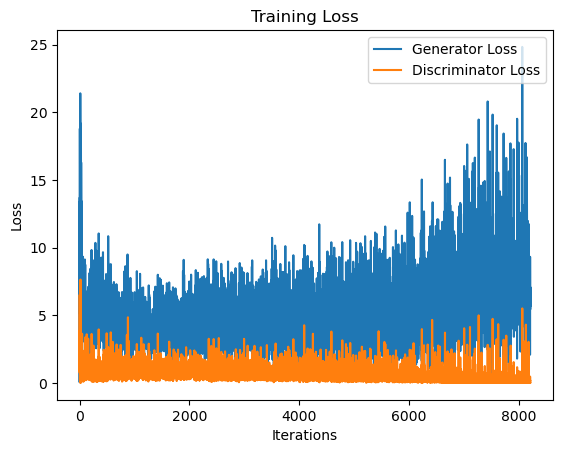

In [18]:
plot_losses(lossD, lossG, epochs, gan_type="Discriminator")

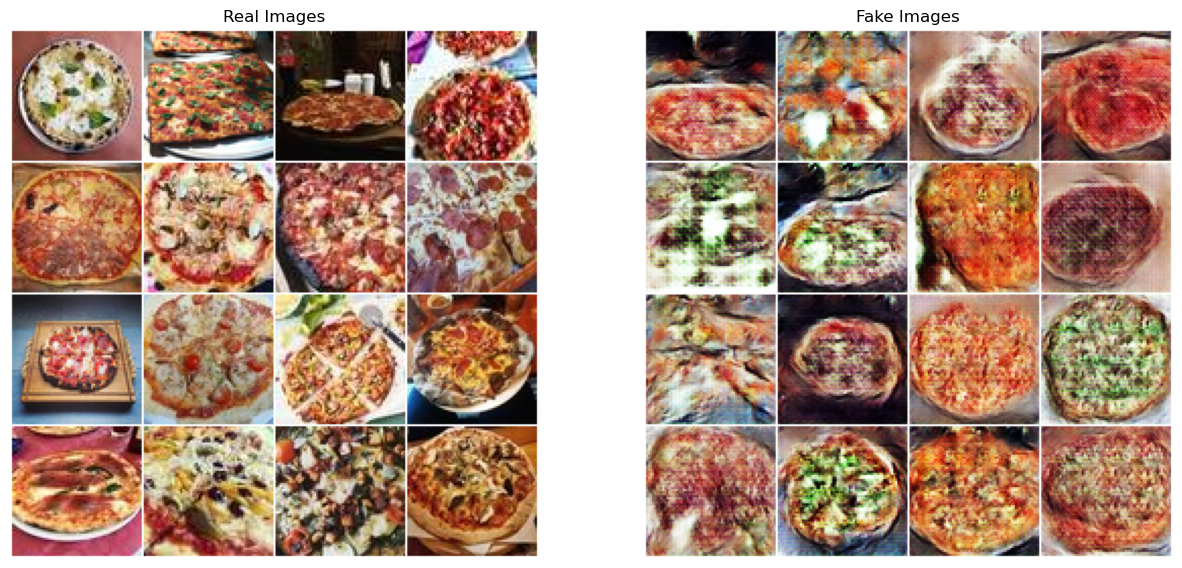

In [26]:
plot_fake_real_images(image_list, trainloader)

#### Evaluation

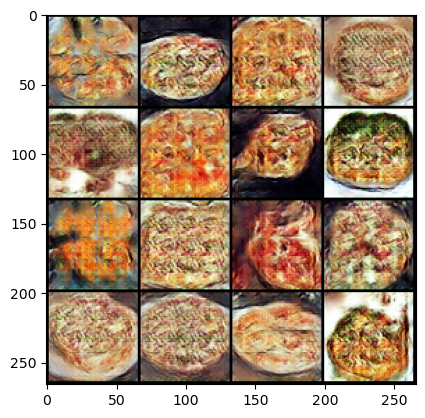

In [27]:
num_images = 1000
validation_noise = torch.randn(num_images, 100, 1, 1, device=device)
netG.load_state_dict(torch.load(os.path.join(path_to_model, "dcgan_generator.pt")))
netG.eval()

generated_fake_images = netG(validation_noise)
fake_images = generated_fake_images.detach().cpu()
plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images[:batch_size], padding=2, nrow=4, normalize=True),(1,2,0)))

In [28]:
# Saving all the fake images
path_to_fakes = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/fakes_dcgan"
for ibx in range(len(fake_images)):
    image = transform_tensor_to_PIL(fake_images[ibx] / 2 + 0.5)
    image.save(os.path.join(path_to_fakes, str(ibx)+".jpg"))

In [29]:
fake_paths = [os.path.join(path_to_fakes, filename) for filename in os.listdir(path_to_fakes)]

path_to_eval = os.path.join(eval_dir, "pizza")
real_paths = [os.path.join(path_to_eval, filename) for filename in os.listdir(path_to_eval)]

In [30]:
dcgan_fid = compute_fid_score(fake_paths, real_paths, dims=2048)

100%|██████████| 20/20 [00:01<00:00, 12.28it/s]


FID: 122.00


### Wasser GAN

#### Train

In [19]:
# Parameters for training Wasser GAN
lr = 1e-3 # Learning Rate
betas = (0.5, 0.999) # Betas factor
epochs = 250 # Number of epochs to train
netG = Generator()
netC = Critic()
LAMBDA = 10
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=betas) # Adam Optimizer for Generator
optimizerC = torch.optim.Adam(netC.parameters(), lr=lr, betas=betas) # Adam Optimizer for Critic

In [20]:
def compute_gradient_penalty(netC, real_images_in_batch, fake_images):
    epsilon = torch.rand(1).cuda()
    interpolates = epsilon * real_images_in_batch + ((1 - epsilon) * fake_images)
    interpolates = interpolates.requires_grad_(True).cuda() 
    critic_interpolates = netC(interpolates)
    gradients = torch.autograd.grad(outputs=critic_interpolates, inputs=interpolates,
                                grad_outputs=torch.ones(critic_interpolates.size()).cuda(), 
                                create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [21]:
def WGAN_train(netC, netG, trainloader):
    nz = 100 # Set the number of channels for the 1x1 input noise vectors for the Generator
    
    # Push networks to GPU and apply weights initalized 
    netC = netC.to(device)
    netC.apply(weights_init)
    
    netG = netG.to(device)
    netG.apply(weights_init)
    
    # Use the same noise batch to check on the progress made for the Generator
    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    
    # To train the Critic, label=1 is assigned to the actual training images and label=-1 assigned to the fake images produced by the Generator
    one = torch.tensor([1], dtype=torch.float).to(device)
    minus_one = torch.tensor([-1], dtype=torch.float).to(device)
    
    # Store all the results during training
    image_list = []
    lossesG = []
    lossesC = []
    iters = 0
    gen_iterations = 0
    
    print(f"Training started at time {datetime.datetime.now().time()}")
    start_time = time.time()
    
    for epoch in range(1, epochs+1):
        data_iter = iter(trainloader)
        batch_idx, ncritic = 0, 5
        
        # A minimization of the Wasserstein distance between the distribution that describes the training data
        # and the distribution that has been learned so far by the Generator can be translated into a maximization
        # of the difference of the average outputs of a 1-Lipschitz function as applied to the training images
        # and as applied to the output of the Generator. Learning this 1-Lipschitz function is the job of the critic
        
        # Since the Critic and the Generator parameters must be updated independently, we start by turning on the
        # requires_grad property of the Critic parameters
        
        while(batch_idx < len(trainloader)):
            for p in netC.parameters():
                p.requires_grad = True
            ic = 0
            
            """
            The following while loop is used to compute the equation:
            
                                     _    _              _    _
                                    |      |            |      |
           Critic Loss     =     E  | C(y) |    -    E  | C(x) |
                                y~Q |_    _|        x~P |_    _|

                                      _       _              _    _
                                     |         |            |      |
                           =     E   | C(G(z)) |     -    E | C(x) |                   
                                z~p_z|_       _|         x~P|_    _|

            """
            while(ic < ncritic and batch_idx < len(trainloader)):
                ic += 1
                ## The maximization needed for training the critic as shown in the above equation consists of three parts
                
                ### Part 1 - Apply the Critic network to the training images with each image subject to a 
                ### gradient target of -1
                netC.zero_grad()
                real_images_in_batch, _ = next(data_iter)
                batch_idx += 1
                real_images_in_batch = real_images_in_batch.to(device)
                
                assert batch_size == real_images_in_batch.size(0), "The batch size are not equal"
                critic_for_reals_mean = netC(real_images_in_batch)
                critic_for_reals_mean.backward(minus_one)
                
                ### Part 2 - Apply the Critic to the images produced by the generator for a fresh batch of 
                ### input noise vectors. The output of the Critic for these images must be subject to the target 1
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fake_images = netG(noise)
                
                critic_for_fakes_mean = netC(fake_images.detach())
                critic_for_fakes_mean.backward(one)
                
                ### Part 3 - Estimate the Gradient Penalty of the function being learned by the Critics with respect to the input to the function
                gradient_penalty = compute_gradient_penalty(netC, real_images_in_batch, fake_images)
                gradient_penalty.backward()
                wasser_dist = critic_for_reals_mean - critic_for_fakes_mean
                loss_critic = -wasser_dist + gradient_penalty
                
                optimizerC.step()
            
            # Training the Generator
            ## Training the Generator through the minimization required by the minmax objective in the equation:
            """
            
                     _                                               _
                    |                                                 |
          min  max  |  E      [C(x)]      -     E         [C(G(z))]   |                  
           G    C   |_  x ~ P                    z ~ p_Z             _|
                                                                         
            
            """
            # First turn off the requires_grad of the Critic parameters since the Critic and Generator must be
            # updated independently
            for p in netC.parameters():
                p.requires_grad = False
            netG.zero_grad()
            
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            critic_for_fakes_mean = netC(fake_images)
            loss_gen = critic_for_fakes_mean
            loss_gen.backward(minus_one)
            
            optimizerG.step()
            gen_iterations += 1
            
            if batch_idx % (ncritic * 20) == 0:                                                        
                print("[epoch=%d/%d   batch_idx=%4d]     loss_critic=%7.4f   loss_gen=%7.4f   Wasserstein_dist=%7.4f" %  (epoch,epochs,batch_idx,loss_critic.data[0], loss_gen.data[0], wasser_dist.data[0]))
                torch.save(netC.state_dict(), os.path.join(path_to_model, "wgan_critic.pt"))
                torch.save(netG.state_dict(), os.path.join(path_to_model, "wgan_generator.pt"))
            
            lossesG.append(loss_gen.data[0].item())      
            lossesC.append(loss_critic.data[0].item())   
            
            if((iters % 500 == 0) or ((epoch == epochs) and (batch_idx == len(trainloader)-1))): 
                with torch.no_grad():                                                                        
                    fake = netG(fixed_noise).detach().cpu()  
                image_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, nrow=4, normalize=True))   
            iters += 1                                               
                
    print("Training concluded in %s seconds" % (time.time() - start_time))
    return lossesC, lossesG, image_list

In [22]:
lossC, lossG, image_list = WGAN_train(netC, netG, trainloader)

Training started at time 22:46:07.645344
[epoch=1/250   batch_idx= 100]     loss_critic=-1967016.0000   loss_gen=-6488790.0000   Wasserstein_dist=2677181.5000
[epoch=1/250   batch_idx= 200]     loss_critic=-6438153.0000   loss_gen=-249809.5469   Wasserstein_dist=8539776.0000
[epoch=1/250   batch_idx= 300]     loss_critic=-3537409.5000   loss_gen=-2259114.5000   Wasserstein_dist=5267549.5000
[epoch=1/250   batch_idx= 400]     loss_critic=-1344158.0000   loss_gen=-6731146.0000   Wasserstein_dist=1643505.5000
[epoch=1/250   batch_idx= 500]     loss_critic=-6659457.5000   loss_gen=9509967.0000   Wasserstein_dist=10510848.0000
[epoch=2/250   batch_idx= 100]     loss_critic=-8008658.0000   loss_gen=-3498859.0000   Wasserstein_dist=11045224.0000
[epoch=2/250   batch_idx= 200]     loss_critic=-4844988.0000   loss_gen=14892770.0000   Wasserstein_dist=7910914.0000
[epoch=2/250   batch_idx= 300]     loss_critic=-4326864.0000   loss_gen=15880936.0000   Wasserstein_dist=8258891.0000
[epoch=2/250   

[epoch=15/250   batch_idx= 100]     loss_critic=-963109.8750   loss_gen=15464351.0000   Wasserstein_dist=2332478.0000
[epoch=15/250   batch_idx= 200]     loss_critic=-1629527.2500   loss_gen=9224507.0000   Wasserstein_dist=2989388.0000
[epoch=15/250   batch_idx= 300]     loss_critic=-920436.5000   loss_gen=-5652142.0000   Wasserstein_dist=2103993.0000
[epoch=15/250   batch_idx= 400]     loss_critic=-674503.2500   loss_gen=996401.9375   Wasserstein_dist=1745335.7500
[epoch=15/250   batch_idx= 500]     loss_critic=-342815.2500   loss_gen=15549511.0000   Wasserstein_dist=1607628.0000
[epoch=16/250   batch_idx= 100]     loss_critic=-1863195.1250   loss_gen=2212223.2500   Wasserstein_dist=3354433.2500
[epoch=16/250   batch_idx= 200]     loss_critic=-1387358.0000   loss_gen=12120494.0000   Wasserstein_dist=2344584.0000
[epoch=16/250   batch_idx= 300]     loss_critic=-993054.7500   loss_gen=10920782.0000   Wasserstein_dist=2334408.0000
[epoch=16/250   batch_idx= 400]     loss_critic=-1763233.

[epoch=29/250   batch_idx= 100]     loss_critic=-709054.0000   loss_gen=-5340605.0000   Wasserstein_dist=1379272.0000
[epoch=29/250   batch_idx= 200]     loss_critic=-1099421.3750   loss_gen=-3311122.5000   Wasserstein_dist=1676657.0000
[epoch=29/250   batch_idx= 300]     loss_critic=-2385223.5000   loss_gen=-7463267.0000   Wasserstein_dist=3908646.2500
[epoch=29/250   batch_idx= 400]     loss_critic=2749.7500   loss_gen=10209951.0000   Wasserstein_dist=671930.0000
[epoch=29/250   batch_idx= 500]     loss_critic=-2051158.3750   loss_gen=-4059403.2500   Wasserstein_dist=2770597.7500
[epoch=30/250   batch_idx= 100]     loss_critic=-693743.9375   loss_gen=849316.5000   Wasserstein_dist=1200861.5000
[epoch=30/250   batch_idx= 200]     loss_critic=-1103413.5000   loss_gen=922961.3750   Wasserstein_dist=1602418.7500
[epoch=30/250   batch_idx= 300]     loss_critic=-1139067.6250   loss_gen=-8970440.0000   Wasserstein_dist=1688864.0000
[epoch=30/250   batch_idx= 400]     loss_critic=-491295.250

[epoch=43/250   batch_idx= 100]     loss_critic=-319409.3125   loss_gen=-1018795.7500   Wasserstein_dist=1074836.2500
[epoch=43/250   batch_idx= 200]     loss_critic=-915613.5625   loss_gen=972152.2500   Wasserstein_dist=1510602.3750
[epoch=43/250   batch_idx= 300]     loss_critic=-1443708.3750   loss_gen=4127290.0000   Wasserstein_dist=2087716.5000
[epoch=43/250   batch_idx= 400]     loss_critic=-656218.4375   loss_gen=1862874.0000   Wasserstein_dist=1237068.2500
[epoch=43/250   batch_idx= 500]     loss_critic=-671086.2500   loss_gen=1498505.0000   Wasserstein_dist=1175047.5000
[epoch=44/250   batch_idx= 100]     loss_critic=-705854.7500   loss_gen=3617684.5000   Wasserstein_dist=1380343.2500
[epoch=44/250   batch_idx= 200]     loss_critic=-762233.6250   loss_gen=-936618.0000   Wasserstein_dist=1462591.0000
[epoch=44/250   batch_idx= 300]     loss_critic=-441579.8750   loss_gen=2340594.0000   Wasserstein_dist=1094482.5000
[epoch=44/250   batch_idx= 400]     loss_critic=-182998.3750   

[epoch=57/250   batch_idx= 200]     loss_critic=-925664.3750   loss_gen=825214.6250   Wasserstein_dist=1446496.7500
[epoch=57/250   batch_idx= 300]     loss_critic=-410576.6875   loss_gen=-1853576.6250   Wasserstein_dist=1004597.3750
[epoch=57/250   batch_idx= 400]     loss_critic=-556746.2500   loss_gen=1253332.5000   Wasserstein_dist=1008386.6250
[epoch=57/250   batch_idx= 500]     loss_critic=-1614924.5000   loss_gen=1692393.7500   Wasserstein_dist=2389132.5000
[epoch=58/250   batch_idx= 100]     loss_critic=-1042266.4375   loss_gen=2041418.2500   Wasserstein_dist=1581383.2500
[epoch=58/250   batch_idx= 200]     loss_critic=-648896.1250   loss_gen=678111.3750   Wasserstein_dist=1143646.2500
[epoch=58/250   batch_idx= 300]     loss_critic=-297971.5000   loss_gen=4426436.0000   Wasserstein_dist=912833.0000
[epoch=58/250   batch_idx= 400]     loss_critic=-797326.5000   loss_gen=3808514.5000   Wasserstein_dist=1412757.2500
[epoch=58/250   batch_idx= 500]     loss_critic=-1268667.1250   

[epoch=71/250   batch_idx= 300]     loss_critic=-888352.9375   loss_gen=4878085.5000   Wasserstein_dist=1364532.0000
[epoch=71/250   batch_idx= 400]     loss_critic=-351638.9375   loss_gen=3108309.2500   Wasserstein_dist=742925.0000
[epoch=71/250   batch_idx= 500]     loss_critic=-786353.3125   loss_gen=2198478.2500   Wasserstein_dist=1263059.5000
[epoch=72/250   batch_idx= 100]     loss_critic=-401630.9062   loss_gen=3765882.0000   Wasserstein_dist=854257.0000
[epoch=72/250   batch_idx= 200]     loss_critic=8871.8125   loss_gen=1761257.7500   Wasserstein_dist=438688.0000
[epoch=72/250   batch_idx= 300]     loss_critic=-644607.0000   loss_gen=4567056.0000   Wasserstein_dist=1070960.0000
[epoch=72/250   batch_idx= 400]     loss_critic=-727504.1250   loss_gen=841709.1250   Wasserstein_dist=1209593.1250
[epoch=72/250   batch_idx= 500]     loss_critic=-1491452.8750   loss_gen=-1288214.7500   Wasserstein_dist=1940482.5000
[epoch=73/250   batch_idx= 100]     loss_critic=-680665.8750   loss_g

[epoch=85/250   batch_idx= 400]     loss_critic=-494175.6250   loss_gen=1589973.1250   Wasserstein_dist=855146.2500
[epoch=85/250   batch_idx= 500]     loss_critic=-518179.1875   loss_gen=650547.4375   Wasserstein_dist=847197.3750
[epoch=86/250   batch_idx= 100]     loss_critic=-612208.5625   loss_gen=2241054.0000   Wasserstein_dist=1012095.2500
[epoch=86/250   batch_idx= 200]     loss_critic=-520269.7500   loss_gen=2736623.0000   Wasserstein_dist=845892.2500
[epoch=86/250   batch_idx= 300]     loss_critic=55726.2188   loss_gen=3120183.7500   Wasserstein_dist=415486.0000
[epoch=86/250   batch_idx= 400]     loss_critic=-1181503.7500   loss_gen=-3584118.0000   Wasserstein_dist=1598621.5000
[epoch=86/250   batch_idx= 500]     loss_critic=-982663.6875   loss_gen=3185726.2500   Wasserstein_dist=1399725.0000
[epoch=87/250   batch_idx= 100]     loss_critic=-549738.2500   loss_gen=7628672.0000   Wasserstein_dist=1038974.5000
[epoch=87/250   batch_idx= 200]     loss_critic=-1175209.1250   loss_

[epoch=99/250   batch_idx= 500]     loss_critic=-774410.0625   loss_gen=10702938.0000   Wasserstein_dist=1303585.0000
[epoch=100/250   batch_idx= 100]     loss_critic=84920.2500   loss_gen=-3145526.0000   Wasserstein_dist=157384.0000
[epoch=100/250   batch_idx= 200]     loss_critic=-298278.1562   loss_gen=270292.1875   Wasserstein_dist=535199.2500
[epoch=100/250   batch_idx= 300]     loss_critic=-350080.7500   loss_gen=9003346.0000   Wasserstein_dist=803031.0000
[epoch=100/250   batch_idx= 400]     loss_critic=-1027407.8125   loss_gen=-3885884.2500   Wasserstein_dist=1372545.2500
[epoch=100/250   batch_idx= 500]     loss_critic=-670554.3125   loss_gen=-5871417.0000   Wasserstein_dist=908617.5000
[epoch=101/250   batch_idx= 100]     loss_critic=-404221.1875   loss_gen=232484.0469   Wasserstein_dist=686444.7500
[epoch=101/250   batch_idx= 200]     loss_critic=-733845.7500   loss_gen=-2157094.5000   Wasserstein_dist=1081582.2500
[epoch=101/250   batch_idx= 300]     loss_critic=-125178.000

[epoch=114/250   batch_idx= 100]     loss_critic=-465481.7188   loss_gen=904814.8750   Wasserstein_dist=791396.8750
[epoch=114/250   batch_idx= 200]     loss_critic=-272385.8750   loss_gen=3973538.7500   Wasserstein_dist=598732.0000
[epoch=114/250   batch_idx= 300]     loss_critic=-583099.0625   loss_gen=4986362.0000   Wasserstein_dist=967251.0000
[epoch=114/250   batch_idx= 400]     loss_critic=-267137.8750   loss_gen=1760455.8750   Wasserstein_dist=551480.6250
[epoch=114/250   batch_idx= 500]     loss_critic=-289234.7500   loss_gen=2637213.0000   Wasserstein_dist=625583.0000
[epoch=115/250   batch_idx= 100]     loss_critic=-422550.8125   loss_gen=1102135.0000   Wasserstein_dist=715202.0000
[epoch=115/250   batch_idx= 200]     loss_critic=-270012.3125   loss_gen=129880.3672   Wasserstein_dist=613250.1250
[epoch=115/250   batch_idx= 300]     loss_critic=629298.5000   loss_gen=2379182.5000   Wasserstein_dist=-180210.5000
[epoch=115/250   batch_idx= 400]     loss_critic=-250611.0000   lo

[epoch=128/250   batch_idx= 200]     loss_critic=-930200.6875   loss_gen=3528868.0000   Wasserstein_dist=1230520.5000
[epoch=128/250   batch_idx= 300]     loss_critic=-530830.8750   loss_gen=298820.9688   Wasserstein_dist=851258.3750
[epoch=128/250   batch_idx= 400]     loss_critic=-600270.8125   loss_gen=-2094688.5000   Wasserstein_dist=1014585.3750
[epoch=128/250   batch_idx= 500]     loss_critic=-367246.1562   loss_gen=1731802.5000   Wasserstein_dist=650017.5000
[epoch=129/250   batch_idx= 100]     loss_critic=563920.5000   loss_gen=-1442055.1250   Wasserstein_dist=-105006.8750
[epoch=129/250   batch_idx= 200]     loss_critic=-375572.9062   loss_gen=976574.1250   Wasserstein_dist=653210.0625
[epoch=129/250   batch_idx= 300]     loss_critic=-851177.7500   loss_gen=2362365.2500   Wasserstein_dist=1163369.2500
[epoch=129/250   batch_idx= 400]     loss_critic=-451010.3750   loss_gen=2185233.0000   Wasserstein_dist=731351.5000
[epoch=129/250   batch_idx= 500]     loss_critic=-446625.8125

[epoch=142/250   batch_idx= 300]     loss_critic=-656226.9375   loss_gen=164306.9688   Wasserstein_dist=945426.7500
[epoch=142/250   batch_idx= 400]     loss_critic=-126635.9375   loss_gen=-1564898.5000   Wasserstein_dist=507402.0000
[epoch=142/250   batch_idx= 500]     loss_critic=-438745.8438   loss_gen=-128512.4844   Wasserstein_dist=750852.6250
[epoch=143/250   batch_idx= 100]     loss_critic=-603583.0625   loss_gen=59044.0859   Wasserstein_dist=886811.3750
[epoch=143/250   batch_idx= 200]     loss_critic=-566579.3750   loss_gen=3467870.5000   Wasserstein_dist=883240.7500
[epoch=143/250   batch_idx= 300]     loss_critic=-378673.3438   loss_gen=3216346.5000   Wasserstein_dist=708889.2500
[epoch=143/250   batch_idx= 400]     loss_critic=-174444.9375   loss_gen=475468.5000   Wasserstein_dist=471275.3125
[epoch=143/250   batch_idx= 500]     loss_critic=-814578.1250   loss_gen=1591045.8750   Wasserstein_dist=1145250.2500
[epoch=144/250   batch_idx= 100]     loss_critic=-408214.3125   lo

[epoch=156/250   batch_idx= 400]     loss_critic=-264481.2812   loss_gen=2036339.2500   Wasserstein_dist=619575.5000
[epoch=156/250   batch_idx= 500]     loss_critic=-356525.5625   loss_gen=1728592.8750   Wasserstein_dist=682172.3750
[epoch=157/250   batch_idx= 100]     loss_critic=-456348.8750   loss_gen=2523220.2500   Wasserstein_dist=768953.7500
[epoch=157/250   batch_idx= 200]     loss_critic=-194250.5625   loss_gen=4119546.5000   Wasserstein_dist=571981.5000
[epoch=157/250   batch_idx= 300]     loss_critic=-83725.3750   loss_gen=649601.0625   Wasserstein_dist=452266.5000
[epoch=157/250   batch_idx= 400]     loss_critic=343763.5938   loss_gen=3502552.7500   Wasserstein_dist=157820.0000
[epoch=157/250   batch_idx= 500]     loss_critic=-425380.0312   loss_gen=1381270.0000   Wasserstein_dist=737032.5000
[epoch=158/250   batch_idx= 100]     loss_critic=-293207.0938   loss_gen=1792172.0000   Wasserstein_dist=601918.5000
[epoch=158/250   batch_idx= 200]     loss_critic=-808293.5625   los

[epoch=170/250   batch_idx= 500]     loss_critic=-235967.0938   loss_gen=2901548.7500   Wasserstein_dist=634375.2500
[epoch=171/250   batch_idx= 100]     loss_critic=-285932.9062   loss_gen=1713030.5000   Wasserstein_dist=622095.2500
[epoch=171/250   batch_idx= 200]     loss_critic=-489362.7500   loss_gen=711252.3750   Wasserstein_dist=904738.0000
[epoch=171/250   batch_idx= 300]     loss_critic=-712512.3125   loss_gen=865368.3125   Wasserstein_dist=1068921.7500
[epoch=171/250   batch_idx= 400]     loss_critic=-684814.7500   loss_gen=1885900.3750   Wasserstein_dist=1043511.5000
[epoch=171/250   batch_idx= 500]     loss_critic=-293281.2188   loss_gen=-154007.8750   Wasserstein_dist=669826.0625
[epoch=172/250   batch_idx= 100]     loss_critic=-613086.6875   loss_gen=550764.7500   Wasserstein_dist=1027908.3750
[epoch=172/250   batch_idx= 200]     loss_critic=-426952.0312   loss_gen=828501.1250   Wasserstein_dist=777730.6250
[epoch=172/250   batch_idx= 300]     loss_critic=-68736.3438   lo

[epoch=185/250   batch_idx= 100]     loss_critic=-664313.4375   loss_gen=2917133.7500   Wasserstein_dist=1043351.5000
[epoch=185/250   batch_idx= 200]     loss_critic=-35388.9062   loss_gen=227359.6562   Wasserstein_dist=485733.0000
[epoch=185/250   batch_idx= 300]     loss_critic=-159669.6250   loss_gen=3962553.0000   Wasserstein_dist=583102.5000
[epoch=185/250   batch_idx= 400]     loss_critic=-203785.8125   loss_gen=2457158.0000   Wasserstein_dist=608984.0000
[epoch=185/250   batch_idx= 500]     loss_critic=-872556.3125   loss_gen=2862740.7500   Wasserstein_dist=1269655.0000
[epoch=186/250   batch_idx= 100]     loss_critic=-984563.1250   loss_gen=2848774.5000   Wasserstein_dist=1384816.7500
[epoch=186/250   batch_idx= 200]     loss_critic=-563645.2500   loss_gen=1346820.5000   Wasserstein_dist=958728.5000
[epoch=186/250   batch_idx= 300]     loss_critic=-250950.4062   loss_gen=1599779.1250   Wasserstein_dist=657450.2500
[epoch=186/250   batch_idx= 400]     loss_critic=228639.9375   

[epoch=199/250   batch_idx= 200]     loss_critic=-605729.2500   loss_gen=23914.1758   Wasserstein_dist=1065201.3750
[epoch=199/250   batch_idx= 300]     loss_critic=-832346.5000   loss_gen=383047.6562   Wasserstein_dist=1282404.1250
[epoch=199/250   batch_idx= 400]     loss_critic=-72064.8125   loss_gen=1499813.7500   Wasserstein_dist=505524.1250
[epoch=199/250   batch_idx= 500]     loss_critic=-472567.9688   loss_gen=1907621.3750   Wasserstein_dist=901408.2500
[epoch=200/250   batch_idx= 100]     loss_critic=-773504.3750   loss_gen=2145510.0000   Wasserstein_dist=1185873.5000
[epoch=200/250   batch_idx= 200]     loss_critic=-485346.3438   loss_gen=1347303.8750   Wasserstein_dist=908789.0000
[epoch=200/250   batch_idx= 300]     loss_critic=-488171.0312   loss_gen=1323966.6250   Wasserstein_dist=950215.7500
[epoch=200/250   batch_idx= 400]     loss_critic=-737131.6875   loss_gen=1852509.2500   Wasserstein_dist=1220729.5000
[epoch=200/250   batch_idx= 500]     loss_critic=-194192.6562   

[epoch=213/250   batch_idx= 200]     loss_critic=-484659.7812   loss_gen=2128232.2500   Wasserstein_dist=960642.7500
[epoch=213/250   batch_idx= 300]     loss_critic=-248422.7188   loss_gen=1993601.7500   Wasserstein_dist=685534.1250
[epoch=213/250   batch_idx= 400]     loss_critic=-462142.3750   loss_gen=1751759.2500   Wasserstein_dist=916561.7500
[epoch=213/250   batch_idx= 500]     loss_critic=-136146.4062   loss_gen=-768596.7500   Wasserstein_dist=588745.0000
[epoch=214/250   batch_idx= 100]     loss_critic=-39168.1875   loss_gen=678608.4375   Wasserstein_dist=564145.3750
[epoch=214/250   batch_idx= 200]     loss_critic=-537556.1875   loss_gen=1949582.0000   Wasserstein_dist=987661.7500
[epoch=214/250   batch_idx= 300]     loss_critic=-505036.0000   loss_gen=654181.3750   Wasserstein_dist=945786.0000
[epoch=214/250   batch_idx= 400]     loss_critic=349006.4062   loss_gen=3200177.5000   Wasserstein_dist=167500.0000
[epoch=214/250   batch_idx= 500]     loss_critic=1166060.5000   loss

[epoch=227/250   batch_idx= 200]     loss_critic=-241947.9375   loss_gen=695777.8750   Wasserstein_dist=784710.8750
[epoch=227/250   batch_idx= 300]     loss_critic=-778723.2500   loss_gen=351725.5938   Wasserstein_dist=1456134.5000
[epoch=227/250   batch_idx= 400]     loss_critic=-1166880.0000   loss_gen=4549444.0000   Wasserstein_dist=1765618.5000
[epoch=227/250   batch_idx= 500]     loss_critic=-291923.0000   loss_gen=3883364.5000   Wasserstein_dist=850622.0000
[epoch=228/250   batch_idx= 100]     loss_critic=-714392.6875   loss_gen=-375986.0312   Wasserstein_dist=1338686.2500
[epoch=228/250   batch_idx= 200]     loss_critic=-417830.9375   loss_gen=1373235.5000   Wasserstein_dist=1007177.9375
[epoch=228/250   batch_idx= 300]     loss_critic=-575950.5625   loss_gen=1504547.6250   Wasserstein_dist=1029623.6250
[epoch=228/250   batch_idx= 400]     loss_critic=-698301.3125   loss_gen=1944733.2500   Wasserstein_dist=1173278.2500
[epoch=228/250   batch_idx= 500]     loss_critic=-512282.81

[epoch=241/250   batch_idx= 200]     loss_critic=-857725.3125   loss_gen=1433312.5000   Wasserstein_dist=1446397.5000
[epoch=241/250   batch_idx= 300]     loss_critic=-509133.9375   loss_gen=2246128.0000   Wasserstein_dist=1082409.5000
[epoch=241/250   batch_idx= 400]     loss_critic=-597165.1250   loss_gen=2457931.7500   Wasserstein_dist=1282518.5000
[epoch=241/250   batch_idx= 500]     loss_critic=-565844.3125   loss_gen=2533207.2500   Wasserstein_dist=1114390.2500
[epoch=242/250   batch_idx= 100]     loss_critic=-737693.5000   loss_gen=725326.2500   Wasserstein_dist=1338053.7500
[epoch=242/250   batch_idx= 200]     loss_critic=-375564.6875   loss_gen=2174480.0000   Wasserstein_dist=1003868.7500
[epoch=242/250   batch_idx= 300]     loss_critic=-318682.0000   loss_gen=1198893.1250   Wasserstein_dist=858065.0000
[epoch=242/250   batch_idx= 400]     loss_critic=-326374.2500   loss_gen=1896048.1250   Wasserstein_dist=857619.7500
[epoch=242/250   batch_idx= 500]     loss_critic=-339964.12

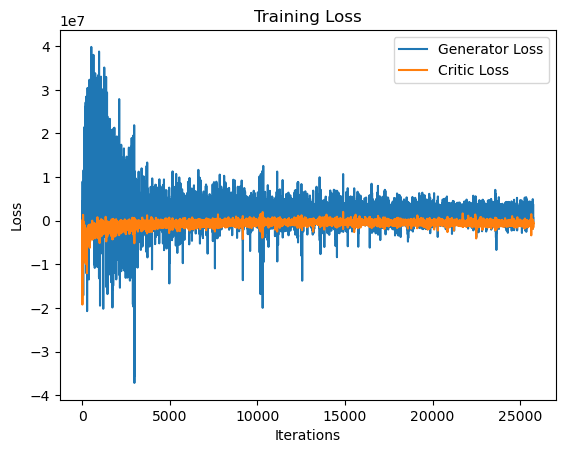

In [23]:
plot_losses(lossC, lossG, epochs, gan_type="Critic")

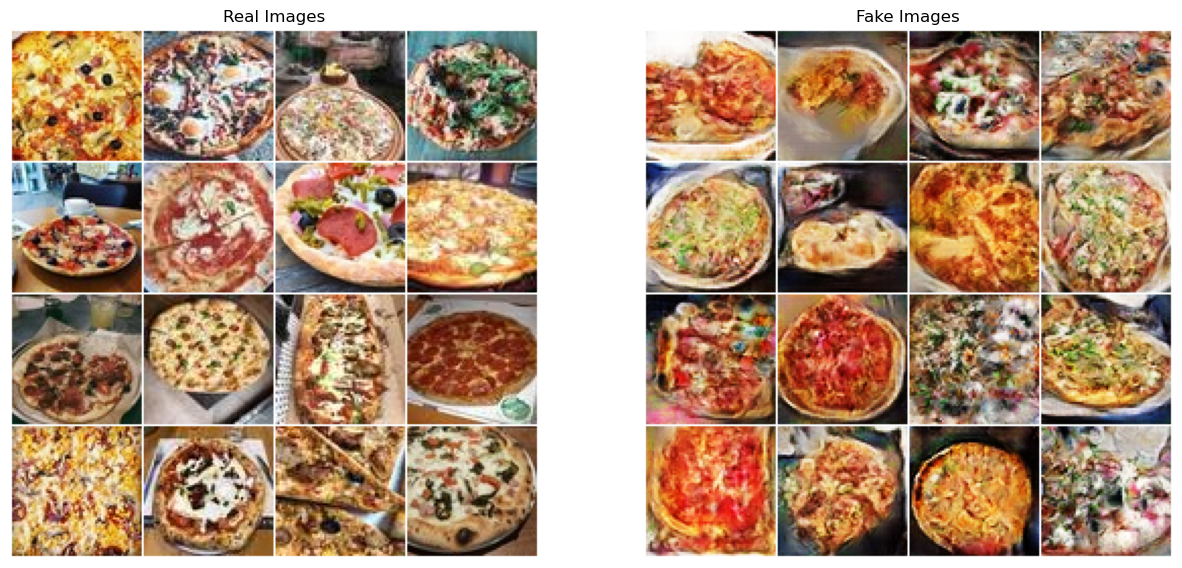

In [42]:
plot_fake_real_images(image_list, trainloader)

#### Evaluation

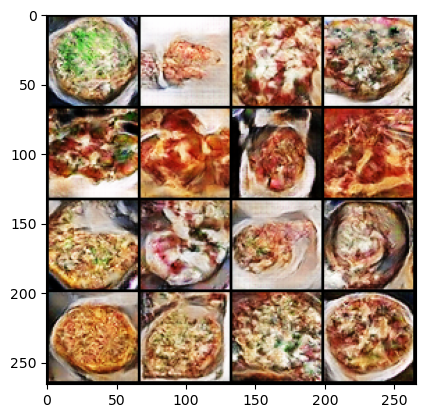

In [43]:
num_images = 1000
validation_noise = torch.randn(num_images, 100, 1, 1, device=device)
netG.load_state_dict(torch.load(os.path.join(path_to_model, "wgan_generator.pt")))
netG.eval()

generated_fake_images = netG(validation_noise)
fake_images = generated_fake_images.detach().cpu()
plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images[:batch_size], padding=2, nrow=4, normalize=True),(1,2,0)))

In [44]:
# Saving all the fake images
path_to_fakes = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw07/fakes_wgan"
for ibx in range(len(fake_images)):
    image = transform_tensor_to_PIL(fake_images[ibx] / 2 + 0.5)
    image.save(os.path.join(path_to_fakes, str(ibx)+".jpg"))

In [45]:
fake_paths = [os.path.join(path_to_fakes, filename) for filename in os.listdir(path_to_fakes)]

path_to_eval = os.path.join(eval_dir, "pizza")
real_paths = [os.path.join(path_to_eval, filename) for filename in os.listdir(path_to_eval)]

In [46]:
wgan_fid = compute_fid_score(fake_paths, real_paths, dims=2048)

100%|██████████| 20/20 [00:01<00:00, 12.22it/s]


FID: 94.07
